## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)


# Arrays to store object points and image points from all the images.




In [2]:
# Step through the list and search for chessboard corners
def getCalibrationParameters(listFileimage, listX, listY):
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    images = []
    for i in range(len(listFileimage)):
        fname = 'camera_cal/' + listFileimage[i]
        x = listX[i]
        y = listY[i]
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        objp = np.zeros((x*y,3), np.float32)
        objp[:,:2] = np.mgrid[0:x,0:y].T.reshape(-1,2)
        ret, corners = cv2.findChessboardCorners(gray, (x,y),None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
        img = cv2.drawChessboardCorners(img, (x,y), corners, ret)
        images.append(img)
        
    return objpoints, imgpoints, images

In [3]:
objpoints, imgpoints, images = getCalibrationParameters(
    [
        'calibration1.jpg',  'calibration2.jpg',  'calibration3.jpg',
        'calibration4.jpg',  'calibration5.jpg',  'calibration6.jpg',
        'calibration7.jpg',  'calibration8.jpg',  'calibration9.jpg',
        'calibration10.jpg', 'calibration11.jpg', 'calibration12.jpg',
        'calibration13.jpg', 'calibration14.jpg', 'calibration15.jpg',
        'calibration16.jpg', 'calibration17.jpg', 'calibration18.jpg',
        'calibration19.jpg', 'calibration20.jpg'        
    ], 
    [
        9,9,9,    #  1  2  3 
        9,9,9,    #  4  5  6
        9,9,9,    #  7  8  9
        9,9,9,    # 10 11 12
        9,9,9,    # 13 14 15
        9,9,9,    # 16 17 18
        9,9       # 19 20
    ], 
    [
        5,6,6,    #  1  2  3
        6,5,6,    #  4  5  6 
        6,6,6,    #  7  8  9
        6,6,6,    # 10 11 12
        6,6,6,    # 13 14 15
        6,6,6,    # 16 17 18
        6,6       # 19 20
    ])

## And so on and so forth...

In [4]:
#img = cv2.imread('camera_cal/calibration3.jpg')
img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)    
img = cv2.undistort(img, mtx, dist, None, mtx)

In [5]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [
            [1280-580, 430],   # top right
            [1280-  0, 720],   # bottom right
            [       0, 720],   # bottom left
            [     580, 430]    # top left

        ]
    )
    dst = np.float32(
        [
            [1280,   0],   # top right
            [1280, 720],   # bottom right
            [   0, 720],   # bottom left
            [   0,   0]    # top left
        ]
    )
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped


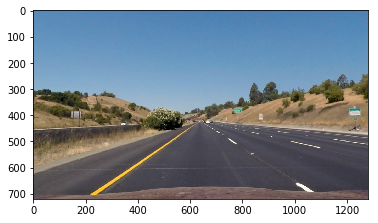

In [6]:
plt.imshow(img)
plt.show()

In [9]:
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]

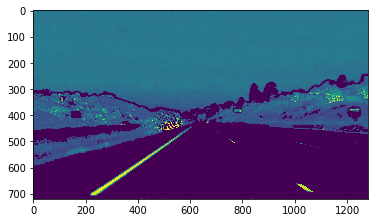

In [14]:
thres_s_channel = cv2.bitwise_and(s_channel, s_channel, mask = cv2.inRange(s_channel, np.array([50], dtype = "uint8"), np.array([255], dtype = "uint8")))
plt.imshow(thres_s_channel)
plt.show()

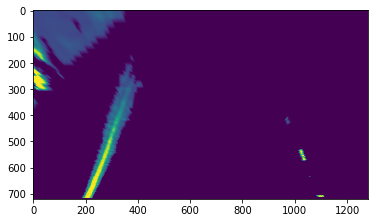

In [15]:
img_warped = warp(thres_s_channel)
plt.imshow(img_warped)
plt.show()